In [1]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit
import random; from collections import Counter; import signalz; from scipy.stats import linregress; from scipy.signal import savgol_filter

font = {'family' : 'serif','weight' : 'ultralight','size'   : 14};mtpl.rc('font', **font)

In [2]:
def Smooth121(x):
    signal = x
    length = len(signal)
    output = np.zeros(length-2)
    coef= np.array([1,2,1])
    for i in range(length - 2):
        output[i]= np.sum(signal[i:i+3] * coef / 4)
    return output

def Haar(t,x,plot=False,smooth=False,bins=20):
    x=np.array(x);t=np.array(t)    
    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    print('t samples:',len(t))
    print('deltas_t steps: from 1 to',len(deltas_t))
    print('epsilons steps:',len(epsilons))

    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                #Hs.append(calib*abs(int2-int1)) #S_1
                Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    #plt.subplots(figsize=(15, 7))
    #plt.title(' Scatter Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
    #plt.plot(data_df['delta t'],np.sqrt(data_df['Hs']),'.');plt.show()

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*bins); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]); upper=np.array([]); lower=np.array([]);
    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
        upper=np.append(upper,np.sqrt(interval.mean()[1]+interval.std()[1]/np.sqrt(len(interval))))
        lower=np.append(lower,np.sqrt(interval.mean()[1]-interval.std()[1]/np.sqrt(len(interval))))
        
    if smooth==False:
        smooth_val=ave_values
    if smooth==True:
        smooth_val=Smooth121(ave_values)
        upper=Smooth121(upper)
        lower=Smooth121(lower)
        time=time[1:-1]
    val_mask = np.isfinite(smooth_val)
    
    time=time[val_mask] #??
    smooth_val=smooth_val[val_mask] #??
    upper=upper[val_mask]
    lower=lower[val_mask]
    
    if plot==True:
        plt.subplots(figsize=(15, 7))
        plt.title(' Sin test Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        plt.plot(time,np.log10(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.legend()
        plt.show()

    return data_sorted['delta t'],data_sorted['Hs'],time,smooth_val,upper,lower

In [3]:
def wave(res1,res2,res3,res4,res5,res6,name):    
    
    kyears1=2; 
    kyears2=10;
    kyears3=20;
    kyears4=50;
    kyears5=100;
    kyears6=200;    
    
    t11 = np.arange(0, kyears1, res1); t21 = np.arange(0, kyears1, res1); t31 = np.arange(0, kyears1, res1);
    x11 = 0.1*np.sin(2000*np.pi*t11/5); x21 = 0.2*np.sin(2000*np.pi*t21/30); x31 = 0.1*np.sin(2000*np.pi*t31/100);
    t41 = np.arange(0, kyears1, res1); t51 = np.arange(0, kyears1, res1); t61 = np.arange(0, kyears1, res1);
    x41 = 3*np.sin(2*np.pi*t41/20); x51 = 2*np.sin(2*np.pi*t51/40); x61 = 1.5*np.sin(2*np.pi*t61/100); 
    T1=x11+x21+x31+x41+x51+x61

    
    t12 = np.arange(kyears1, kyears2, res2); t22 = np.arange(kyears1, kyears2, res2); t32 = np.arange(kyears1, kyears2, res2);
    x12 = 0.1*np.sin(2000*np.pi*t12/5); x22 = 0.2*np.sin(2000*np.pi*t22/30); x32 = 0.1*np.sin(2000*np.pi*t32/100);
    t42 = np.arange(kyears1, kyears2, res2); t52 = np.arange(kyears1, kyears2, res2); t62 = np.arange(kyears1, kyears2, res2);
    x42 = 3*np.sin(2*np.pi*t42/20); x52 = 2*np.sin(2*np.pi*t52/40); x62 = 1.5*np.sin(2*np.pi*t62/100); 
    T2=x12+x22+x32+x42+x52+x62

    t13 = np.arange(kyears2, kyears3, res3); t23 = np.arange(kyears2, kyears3, res3); t33 = np.arange(kyears2, kyears3, res3);
    x13 = 0.1*np.sin(2000*np.pi*t13/5); x23 = 0.2*np.sin(2000*np.pi*t23/30); x33 = 0.1*np.sin(2000*np.pi*t33/100); 
    t43 = np.arange(kyears2, kyears3, res3); t53 = np.arange(kyears2, kyears3, res3); t63 = np.arange(kyears2, kyears3, res3);
    x43 = 3*np.sin(2*np.pi*t43/20); x53 = 2*np.sin(2*np.pi*t53/40); x63 = 1.5*np.sin(2*np.pi*t63/100); 
    T3=x13+x23+x33+x43+x53+x63

    t14 = np.arange(kyears3, kyears4, res4); t24 = np.arange(kyears3, kyears4, res4); t34 = np.arange(kyears3, kyears4, res4);
    x14 = 0.1*np.sin(2000*np.pi*t14/5); x24 = 0.2*np.sin(2000*np.pi*t24/30); x34 = 0.1*np.sin(2000*np.pi*t34/100);
    t44 = np.arange(kyears3, kyears4, res4); t54 = np.arange(kyears3, kyears4, res4); t64 = np.arange(kyears3, kyears4, res4);
    x44 = 3*np.sin(2*np.pi*t44/20); x54 = 2*np.sin(2*np.pi*t54/40); x64 = 1.5*np.sin(2*np.pi*t64/100); 
    T4=x14+x24+x34+x44+x54+x64

    t15 = np.arange(kyears4, kyears5, res5); t25 = np.arange(kyears4, kyears5, res5); t35 = np.arange(kyears4, kyears5, res5);
    x15 = 0.1*np.sin(2000*np.pi*t15/5); x25 = 0.2*np.sin(2000*np.pi*t25/30); x35 = 0.1*np.sin(2000*np.pi*t35/100); 
    t45 = np.arange(kyears4, kyears5, res5); t55 = np.arange(kyears4, kyears5, res5); t65 = np.arange(kyears4, kyears5, res5);
    x45 = 3*np.sin(2*np.pi*t45/20); x55 = 2*np.sin(2*np.pi*t55/40); x65 = 1.5*np.sin(2*np.pi*t65/100); 
    T5=x15+x25+x35+x45+x55+x65

    t16 = np.arange(kyears5, kyears6, res6); t26 = np.arange(kyears5, kyears6, res6); t36 = np.arange(kyears5, kyears6, res6);
    x16 = 0.2*np.sin(2000*np.pi*t16/5); x26 = 0.2*np.sin(2000*np.pi*t26/30); x36 = 0.2*np.sin(2000*np.pi*t36/100);
    t46 = np.arange(kyears5, kyears6, res6); t56 = np.arange(kyears5, kyears6, res6); t66 = np.arange(kyears5, kyears6, res6);
    x46 = 3*np.sin(2*np.pi*t46/20); x56 = 2*np.sin(2*np.pi*t56/40); x66 = 1.5*np.sin(2*np.pi*t66/100); 
    T6=x16+x26+x36+x46+x56+x66

    T=np.concatenate((T1, T2, T3, T4, T5, T6)); t=np.concatenate((t11, t12, t13, t14, t15, t16))
    print('Len T1: ',len(T1),' Len T2: ',len(T2),' Len T3: ',len(T3),' Len T4: ',len(T4),' Len T5: ',len(T5),' Len T6: ',len(T6))
    print('Len total: ',len(T))
    
    colors = ['#2D7FB8','#FF7F17','#2CA02C','#D62728','#9468BD','#A67D75']
    col_dic = {'0.005':'#2D7FB8','0.01':'#FF7F17','0.015':'#2CA02C','0.035':'#2CA02C','0.05':'#D62728','0.1':'#9468BD','0.2':'#A67D75'}

    #plt.subplots(figsize=(17, 8))
    #plt.plot(t11,T1,'-',color=col_dic[str(res1)])#,label=str(res1)+'ky resolution')
    #plt.plot(t12,T2,'-',color=col_dic[str(res2)])#,label=str(res2)+'ky resolution')
    #plt.plot(t13,T3,'-',color=col_dic[str(res3)],label=str(res3)+'ky resolution')
    #plt.plot(t14,T4,'-',color=col_dic[str(res4)],label=str(res4)+'ky resolution')
    #plt.plot(t15,T5,'-',color=col_dic[str(res5)],label=str(res5)+'ky resolution')
    #plt.plot(t16,T6,'-',color=col_dic[str(res6)],label=str(res6)+'ky resolution')

    #plt.title('Resolution '+str(name));plt.xlabel('t (Ky)');plt.ylabel('T (°C)')
    #plt.grid(True, which='both');plt.axhline(y=0, color='k')
    #plt.legend()
    #plt.savefig('1-Resolution test '+str(name)+'.jpg',bbox_inches='tight')
    #plt.show()
    
    #plt.subplots(figsize=(10, 8))
    #plt.plot(t,'--')
    #plt.title('Time steps '+str(name));plt.ylabel('t (Ky)');plt.xlabel('Samples')
    #plt.savefig('1-Time steps '+str(name)+'.jpg',bbox_inches='tight')
    #plt.show()
    
    return t,T

In [21]:
def slopes(time,amp,inicio,fin):
    m=linregress(time[inicio:fin], np.log10(amp[inicio:fin]))[0]
    y=linregress(time[inicio:fin], np.log10(amp[inicio:fin]))[1]
    return m,y

In [4]:
dust_file='Dust records corregidos Completo.xlsx'
#dust_file='Temps records corregidos Completo.xlsx'
#dust_file='Dust records corregidos Completo Uniformes.xlsx'
#dust_file='EDC_DustFlux_25yr.xlsx'
id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units','Data length']
id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)#skip row 1 o 0

#SEPARAR COLUMNAS
columns=df_data.size/len(df_data) ;lis=[];new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() 
        dupla.index=[j for j in range(0, len(dupla))] 
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])
id_data

,Name,Data id,Latitud,Longitud,Age units,Data units,Data length
0,Vostok,1,-78.464167,106.865833,ka,(ug/m2/a),507
1,EPICA Dome C,2,-75.100000,123.350000,ka,(mg/m**2/a),298205
2,EPICA EDML,3,-75.002500,0.068400,ka,(ug/m**2/a),2303
3,Talos Dome,4,-72.817000,159.183000,ka BP,(µg/kg),64998
4,PS75/59-2,5,-54.215000,-125.425500,(kyr),(wt-%),2384
5,ML1208-17PC,6,0.480000,-156.450000,ka,(g/m2/yr),192
6,ML1208-31BB,7,4.680000,-160.050000,ka,(g/m2/yr),254
7,ML1208-37BB,8,7.040000,-161.630000,ka,(g/m2/yr),105
8,Xifeng,9,35.700000,107.600000,ka,(g/m^2/ka),722
9,Chinese Loess Plateau,10,35.760000,107.817333,ka,(g/cm3/ka),1801


In [39]:
[t,T]=wave(0.005,0.01,0.015,0.05,0.2,0.2,'test 1')
ix='reference'

Len T1:  400  Len T2:  800  Len T3:  667  Len T4:  600  Len T5:  250  Len T6:  500
Len total:  3217


In [52]:
ix=6
t=lis[ix][lis[ix].columns[0]]
T=lis[ix][lis[ix].columns[1]]

t samples: 253
deltas_t steps: from 1 to 127
epsilons steps: 127
1160  fluctuaciones eliminadas ( 7.365079365079365 %)


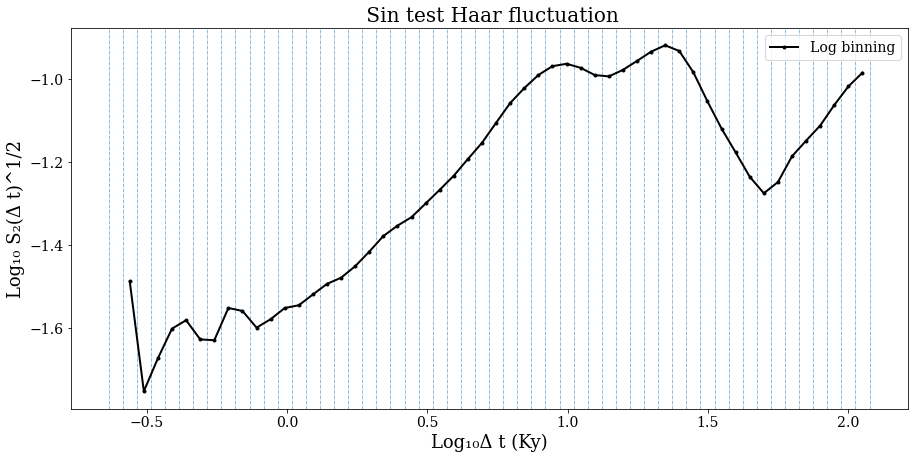

In [53]:
[delta_t,hs,time,amp,app,low]=Haar(t,T,plot=True,smooth=True,bins=20)

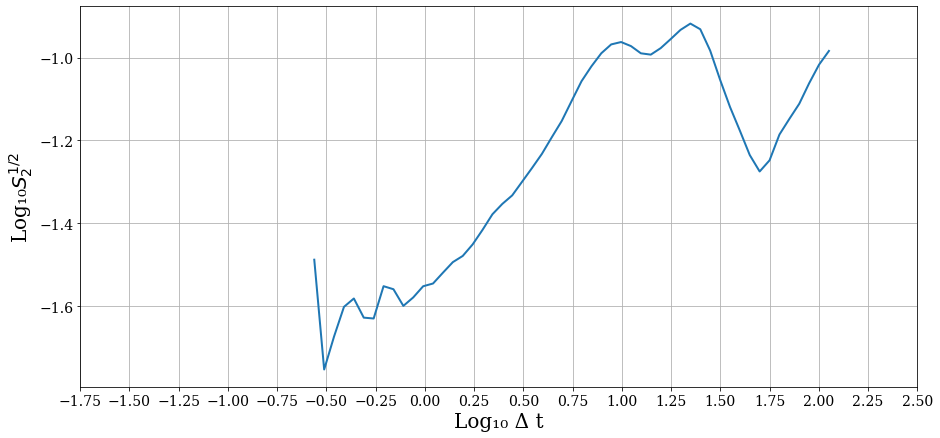

In [55]:
fig, (ax1) = plt.subplots(1,1,figsize=(15, 7))
ax1.plot(time,np.log10(amp),'-',linewidth=2) ###############################################
#ax1.plot(time,amp,'-',linewidth=2)
#ax1.set_xticks([-2,-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.set_xticks([-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_2^{1/2}$', fontsize = 20.0)
ax1.grid()
#ax1.set(xlim=[-0.5,2.5])
#plt.savefig('12-dust ngrip.jpg',bbox_inches='tight')

plt.show()

Possible t_c at:  -0.5615986176987364  =  274.41 y
Possible t_c at:  -0.5113420508554901  =  308.08 y
Possible t_c at:  -0.4610854840122438  =  345.87 y
Possible t_c at:  -0.41082891716899755  =  388.3 y
Possible t_c at:  -0.36057235032575125  =  435.94 y
Possible t_c at:  -0.20980264979601237  =  616.88 y
Possible t_c at:  -0.1595460829527661  =  692.55 y
Possible t_c at:  -0.059032949266273504  =  872.91 y
Possible t_c at:  -0.008776382423027196  =  979.99 y
Possible t_c at:  0.04148018442021906  =  1100.22 y
Possible t_c at:  0.09173675126346531  =  1235.2 y
Possible t_c at:  0.14199331810671162  =  1386.73 y
Possible t_c at:  0.19224988494995793  =  1556.86 y
Possible t_c at:  0.24250645179320424  =  1747.86 y


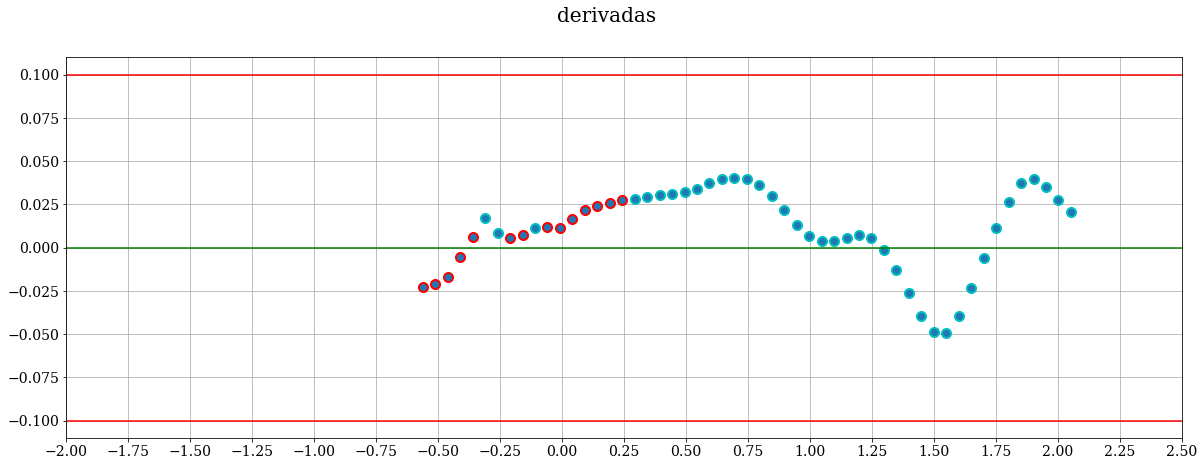

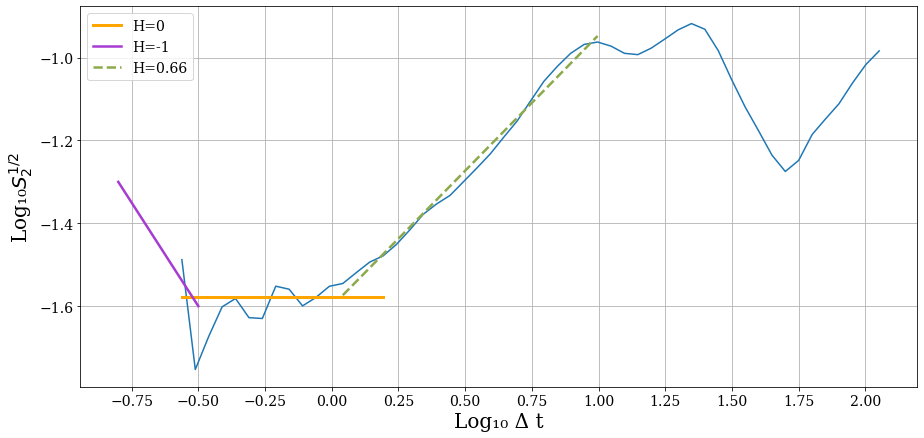

In [69]:
points=9;order=2;ep=0.1

der1=savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=1,mode='nearest')
der2=savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=2,mode='nearest')

fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('derivadas',fontsize=20)
for i in np.where(abs(der1)<ep)[0]:
    if der2[i]>0 and time[i]<0.25 and time[i]>-0.7:                                                                  #PARAMETROO
        ax1.plot(time[i],der1[i],'ro',color='red',markersize=10)
        print('Possible t_c at: ',time[i],' = ',np.round(10**time[i]*1000,2),'y')
    else:
        ax1.plot(time[i],der1[i],'ro',color='c',markersize=10)
ax1.plot(time,der1,'o')
ax1.axhline(y=0,color='green')
ax1.axhline(y=0+ep,color='red')
ax1.axhline(y=0-ep,color='red')
ax1.set_xticks([-2,-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.grid()
plt.show()


possibles_tc=np.array([])
possibles_tc_ix=[]#np.array([])
#PLOT 2
fig, (ax1) = plt.subplots(1,1,figsize=(15, 7));#fig.suptitle('Posible'+r'$\tau_c$',fontsize=20)
ax1.plot(time,np.log10(amp),'-')
for i in np.where(abs(der1)<ep)[0]:
    if der2[i]>0 and time[i]<0.25 and time[i]>-0.7:                                                                  #PARAMETROO
        #ax1.plot(time[i],np.log10(amp[i]),'x',color='red',markersize=10)
        possibles_tc_ix.append(i)
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_2^{1/2}$', fontsize = 20.0)
#ax1.plot(time[possibles_tc_ix[0]:possibles_tc_ix[-1]],np.log10(amp[possibles_tc_ix[0]:possibles_tc_ix[-1]]),'-',color='r')
ax1.set_xticks([-2,-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.grid()

m=linregress(time[possibles_tc_ix[0]:possibles_tc_ix[-1]], np.log10(amp[possibles_tc_ix[0]:possibles_tc_ix[-1]]))[0]
y=np.mean(np.log10(amp[possibles_tc_ix[0]:possibles_tc_ix[-1]]))
ax1.plot(time[possibles_tc_ix[0]:possibles_tc_ix[-1]],time[possibles_tc_ix[0]:possibles_tc_ix[-1]]*0+y,'-',color='orange',linewidth=3,label='H=0')#+str(np.round(m,2)))            

inicio=0
fin=7
[m,y]=slopes(time,amp,inicio,fin)
ax1.plot(np.array([-0.8,-0.75,-0.6,-0.5]),np.array([-0.8,-0.75,-0.6,-0.5])*-1-2.1,color='#a63cd1',linewidth=2.5,label='H=-1')            
#ax1.plot(time[inicio:fin],time[inicio:fin]*-1-2,'--',color='#a63cd1',linewidth=2.5,label='H=-1')            
#ax1.plot(time[inicio:fin],time[inicio:fin]*m+y,'--',color='#a63cd1',linewidth=2.5,label='H='+str(np.round(m,2)))            

inicio=12
fin=32
[m,y]=slopes(time,amp,inicio,fin)
#ax1.plot(time[inicio:fin],time[inicio:fin]*1-0.5,'--',color='#8caa4b',linewidth=2.5,label='H=1')   
ax1.plot(time[inicio:fin],time[inicio:fin]*m+y,'--',color='#8caa4b',linewidth=2.5,label='H='+str(np.round(m,2)))            


plt.legend()

#ax1.set(xlim=[-0.8,2.53])
#plt.savefig('7-ngrip 0.6 a 0.75 ie 3918-5550y.jpg',bbox_inches='tight')
plt.show()

# possibles_tc_ix

In [358]:
#Primero sin distinguir por típo de proxy
latitud=np.array([-78.46])
tc_low=np.array([])
tc_mid=np.array([])
tc_upp=np.array([])

34.394700622934906

In [84]:
dust_file='Taus.xlsx'
id_columns=['Name','Lat','Lower','Upper','Mid','Lower (yr)','Upper (yr)','Mid (yr)']
id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
id_data['Lower (yr)']=np.round(id_data['Lower (yr)'],0)
id_data['Upper (yr)']=np.round(id_data['Upper (yr)'],0)
id_data['Mid (yr)']=np.round(id_data['Mid (yr)'],0)
#df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=0,usecols=id_columns)#skip row 1 o 0

#SEPARAR COLUMNAS
#columns=df_data.size/len(df_data) ;lis=[];new_length=np.array([])

#for i in range(int(columns)):
#    if (i+1)%2==1: 
#        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() 
#        dupla.index=[j for j in range(0, len(dupla))] 
#        lis.append(dupla)
#        new_length=np.append(new_length,np.shape(dupla)[0])
id_data

,Name,Lat,Lower,Mid,Upper,Lower (yr),Mid (yr),Upper (yr)
0,siple dome,-81.65,-0.48,-0.305,-0.13,331.0,495.0,741.0
1,wais,-79.47,-0.74,-0.595,-0.45,182.0,254.0,355.0
2,vostok,-78.46,-0.28,-0.155,-0.03,525.0,700.0,933.0
3,vostok T,-78.46,-0.80,-0.665,-0.53,158.0,216.0,295.0
4,EDML,-75.10,-0.29,-0.160,-0.03,513.0,692.0,933.0
5,EDC T,-75.10,-0.53,-0.330,-0.13,295.0,468.0,741.0
6,PS75,-54.22,-0.46,-0.260,-0.06,347.0,550.0,871.0
7,sajama,-18.10,0.60,0.680,0.76,3981.0,4786.0,5754.0
8,lake,-6.65,-0.08,0.120,0.32,832.0,1318.0,2089.0
9,17PC,0.48,-0.35,-0.200,-0.05,447.0,631.0,891.0


array([['siple dome', -81.65, -0.48, -0.13, -0.305],
       ['wais', -79.47, -0.74, -0.45, -0.595],
       ['vostok', -78.46, -0.28, -0.03, -0.15500000000000003],
       ['vostok T', -78.46, -0.8, -0.53, -0.665],
       ['EDML', -75.1, -0.29, -0.03, -0.15999999999999998],
       ['EDC T', -75.1, -0.53, -0.13, -0.33],
       ['PS75', -54.22, -0.46, -0.06, -0.26],
       ['sajama', -18.1, 0.6, 0.76, 0.6799999999999999],
       ['lake', -6.65, -0.08, 0.32, 0.12000000000000001],
       ['17PC', 0.48, -0.35, -0.05, -0.19999999999999998],
       ['31BB', 4.68, -0.46, -0.01, -0.23500000000000001],
       ['37BB', 7.04, 0.15, 0.35, 0.25],
       ['xifeng', 35.7, 0.12, 0.32, 0.22],
       ['recap', 71.3, 0.0, 0.48, 0.24],
       ['grip', 72.59, -1.5, -0.93, -1.215],
       ['ngrip', 75.0, -1.46, -0.86, -1.16],
       ['ngrip T', 75.1, 0.6, 0.75, 0.675]], dtype=object)

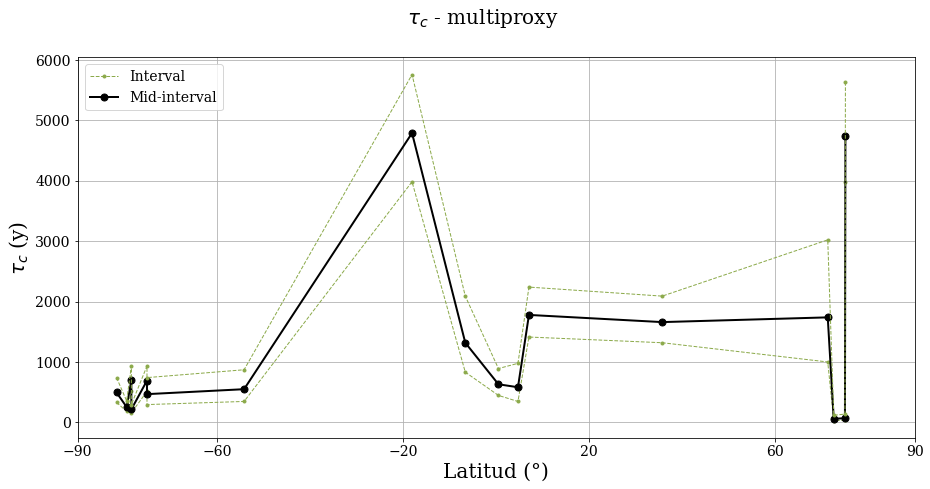

In [68]:
fig, (ax1) = plt.subplots(1,1,figsize=(15, 7));fig.suptitle(r'$\tau_c$ - multiproxy',fontsize=20)
ax1.plot(id_data['Lat'],10**id_data['Lower']*1000,'.--',linewidth=1,color='#8caa4b',label='Interval')
ax1.plot(id_data['Lat'],10**id_data['Mid']*1000,'o-',linewidth=2,color='black',markersize=7,label='Mid-interval')
ax1.plot(id_data['Lat'],10**id_data['Upper']*1000,'.--',linewidth=1,color='#8caa4b')
ax1.set_xticks([-90,-60,-20,20,60,90])
ax1.set_xlabel('Latitud (°)', fontsize = 20.0)
ax1.set_ylabel(r'$\tau_c$ (y)', fontsize = 20.0)
ax1.grid()
ax1.legend()
plt.savefig('tc_multiproxy.jpg',bbox_inches='tight')

plt.show()

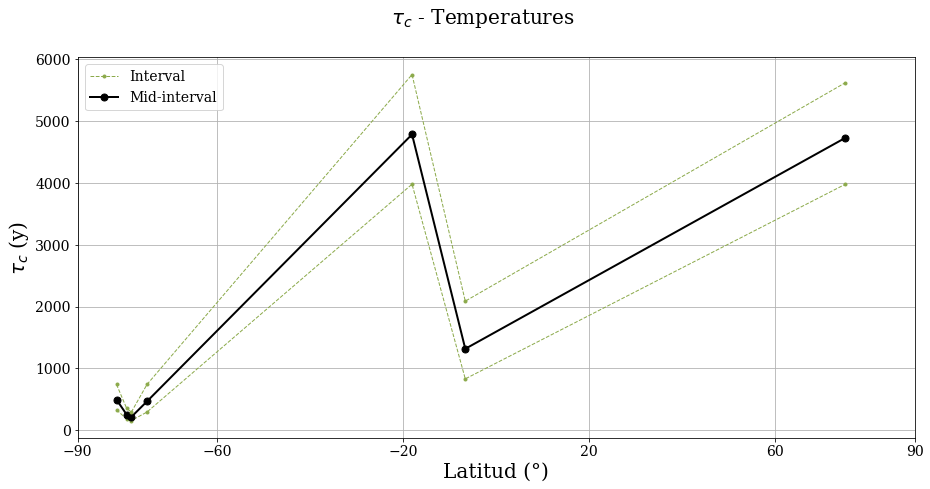

In [70]:
dust_file='Taus.xlsx'
id_columns=['Name','Lat','Lower','Upper','Mid']
id_data=pd.read_excel(dust_file,sheet_name=1,usecols=id_columns)
id_data

fig, (ax1) = plt.subplots(1,1,figsize=(15, 7));fig.suptitle(r'$\tau_c$ - Temperatures',fontsize=20)
ax1.plot(id_data['Lat'],10**id_data['Lower']*1000,'.--',linewidth=1,color='#8caa4b',label='Interval')
ax1.plot(id_data['Lat'],10**id_data['Mid']*1000,'o-',linewidth=2,color='black',markersize=7,label='Mid-interval')
ax1.plot(id_data['Lat'],10**id_data['Upper']*1000,'.--',linewidth=1,color='#8caa4b')
ax1.set_xticks([-90,-60,-20,20,60,90])
ax1.set_xlabel('Latitud (°)', fontsize = 20.0)
ax1.set_ylabel(r'$\tau_c$ (y)', fontsize = 20.0)
ax1.grid()
ax1.legend()
#plt.savefig('tc_temperatures.jpg',bbox_inches='tight')

plt.show()

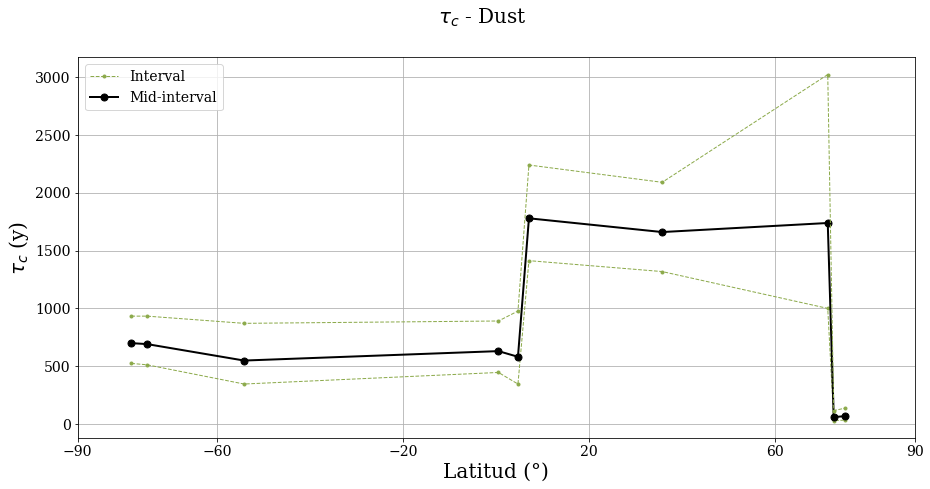

In [72]:
dust_file='Taus.xlsx'
id_columns=['Name','Lat','Lower','Upper','Mid']
id_data=pd.read_excel(dust_file,sheet_name=2,usecols=id_columns)
id_data

fig, (ax1) = plt.subplots(1,1,figsize=(15, 7));fig.suptitle(r'$\tau_c$ - Dust',fontsize=20)
ax1.plot(id_data['Lat'],10**id_data['Lower']*1000,'.--',linewidth=1,color='#8caa4b',label='Interval')
ax1.plot(id_data['Lat'],10**id_data['Mid']*1000,'o-',linewidth=2,color='black',markersize=7,label='Mid-interval')
ax1.plot(id_data['Lat'],10**id_data['Upper']*1000,'.--',linewidth=1,color='#8caa4b')
ax1.set_xticks([-90,-60,-20,20,60,90])
ax1.set_xlabel('Latitud (°)', fontsize = 20.0)
ax1.set_ylabel(r'$\tau_c$ (y)', fontsize = 20.0)
ax1.grid()
ax1.legend()
#plt.savefig('tc_dust.jpg',bbox_inches='tight')

plt.show()

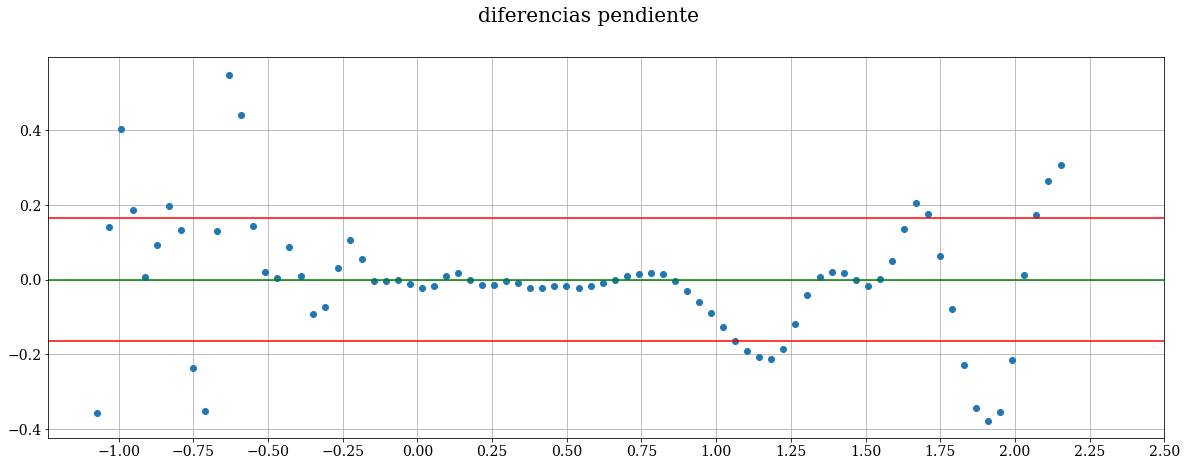

In [132]:
diff1=(der1[1:]-der1[:-1])/(time[1:]-time[:-1])
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('diferencias pendiente',fontsize=20)
ax1.plot(time[:-1],diff1,'o')
ax1.axhline(y=0,color='green')
ax1.axhline(y=np.std(diff1),color='red')
ax1.axhline(y=-np.std(diff1),color='red')
ax1.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.grid()
plt.show()

slope_ix=[]
for i in range(len(diff1)):
    if abs(diff1[i])<0.2:
        slope_ix.append(i)
    else:
        if len(slope_ix)<10:
            slope_ix=[]
        else:
            m=linregress(time[slope_ix], np.log10(amp[slope_ix]))[0]
            y=linregress(time[slope_ix], np.log10(amp[slope_ix]))[1]
            ax1.plot(time[slope_ix],time[slope_ix]*m+y,'-')            

In [61]:
(possibles_tc[1:]-possibles_tc[:-1])*1000

array([ 40.33090988,  40.33090988,  40.33090988, 161.32363954,
        40.33090988,  40.33090988,  40.33090988])

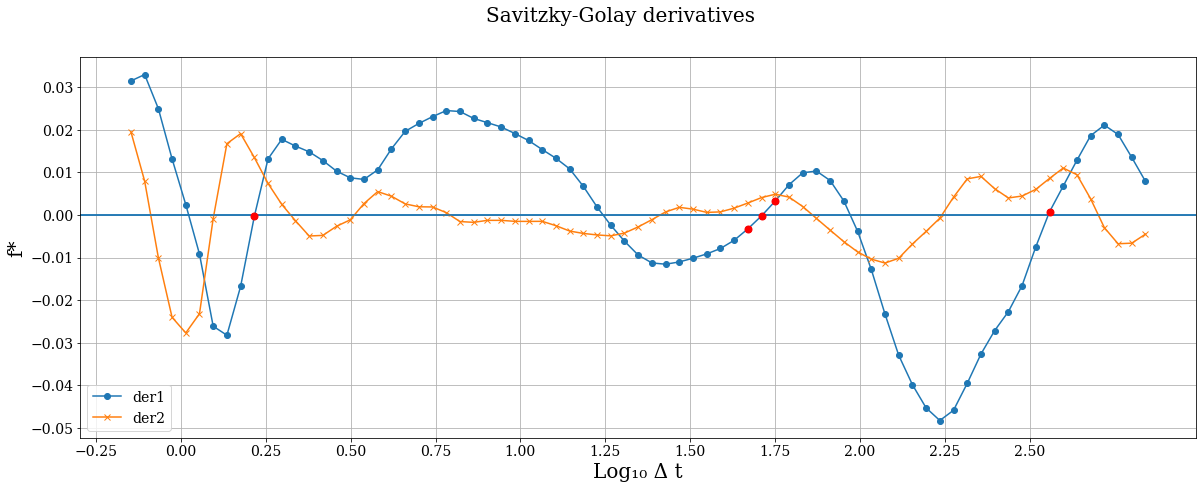

Possible t_c at:  0.2163657230634247  =  1645.76  years


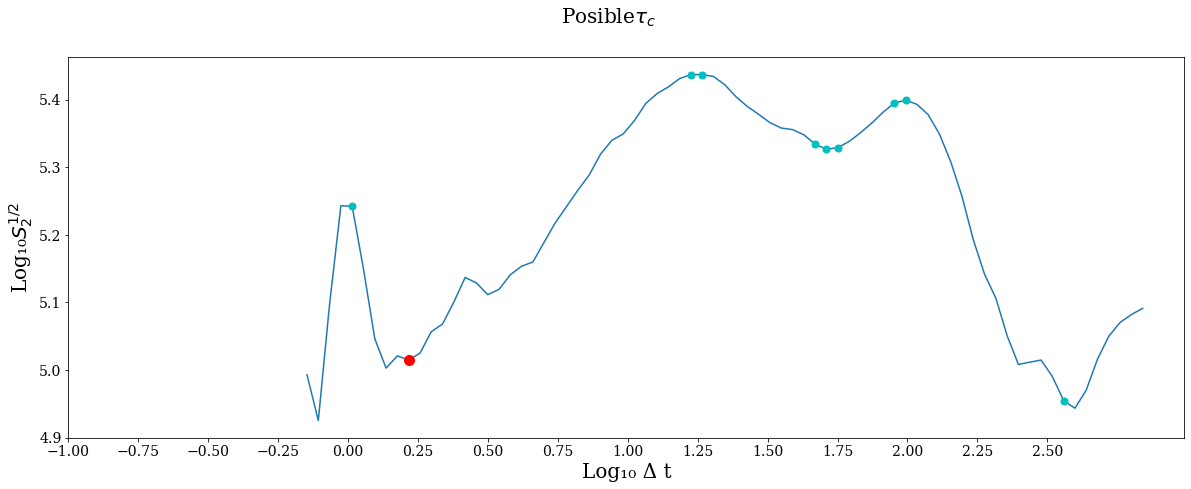

ValueError: x and y must have same first dimension, but have shapes (75,) and (82,)

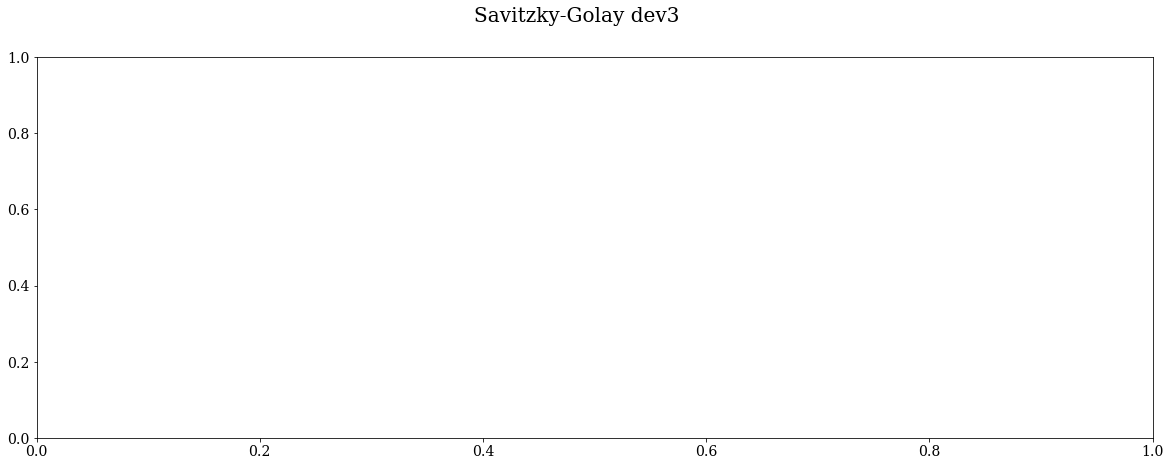

In [175]:
points=9;order=2; win3=21;ep=0.005
der1=savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=1,mode='nearest')
der2=savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=2,mode='nearest')

#PLOT 1
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('Savitzky-Golay derivatives',fontsize=20)
ax1.plot(time,der1,'o-',label='der1');ax1.axhline(y=0);ax1.grid();ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('f*', fontsize = 20);ax1.legend(loc=3);#ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2])
ax1.plot(time,der2,'x-',label='der2');
ax1.axhline(y=0);ax1.grid();ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0);ax1.set_ylabel('f*', fontsize = 20)
ax1.legend(loc=3);#ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2]);
ax1.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]);ax1.grid()
for i in np.where(abs(der1)<ep)[0]:
    if der2[i]>0:
        ax1.plot(time[i],der1[i],'ro',color='r',markersize=7)
plt.show()

#PLOT 2
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('Posible'+r'$\tau_c$',fontsize=20)
ax1.plot(time,np.log10(amp),'-')
for i in np.where(abs(der1)<ep)[0]:
    if der2[i]>0 and time[i]<1:
        ax1.plot(time[i],np.log10(amp[i]),'ro',color='red',markersize=10)
        print('Possible t_c at: ',time[i],' = ',np.round(10**time[i]*1000,2),' years')
    else:
        ax1.plot(time[i],np.log10(amp[i]),'ro',color='c',markersize=7)
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_2^{1/2}$', fontsize = 20.0)
ax1.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
plt.show()


#PLOT 3
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('Savitzky-Golay dev3',fontsize=20)
ax1.plot(time,der3,'o-',label='der1');ax1.axhline(y=0);ax1.grid();ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('f***', fontsize = 20);ax1.legend(loc=3);#ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2])
ax1.axhline(y=0);ax1.grid();ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0);ax1.set_ylabel('f*', fontsize = 20)
ax1.legend(loc=3);#ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2]);
ax1.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]);ax1.grid()
for i in np.where(abs(der1)<0.01)[0]:
    if der2[i]>0:
        ax1.plot(time[i],der3[i],'ro',color='r',markersize=7)
plt.show()


#PLOT 4
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('Puntos a interpolar',fontsize=20)
ax1.plot(time,np.log10(amp),'-')
for i in np.where(abs(der3)<ep)[0]:
    ax1.plot(time[i],np.log10(amp[i]),'ro',color='red',markersize=10)
plt.show()

constantes=np.where(abs(der3)<ep)[0]
print('constantes:\n',constantes)
breaks=np.where(constantes[1:]-constantes[:-1]>1)[0]+1
print('\nbreaks:',breaks)

lines=np.array_split(constantes,breaks,axis=0)
for i in lines:
    print('line:',i)
    
#PLOT 5
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('Posible'+r'$\tau_c$',fontsize=20)
ax1.plot(time,np.log10(amp),'-')
ax1.plot(time[breaks],np.log10(amp[breaks]),'ro',color='y',markersize=10,label='breaks')

for line in lines:
    if len(line)!=1:        
        m=linregress(time[line], np.log10(amp[line]))[0]
        #print(m)
        y=linregress(time[line], np.log10(amp[line]))[1]
        ax1.plot(time[line[0]:line[-1]+1],time[line[0]:line[-1]+1]*m+y,'-')
    else:
        print('ELSE')
        try:
            line.append(line+1)
            m=linregress(time[line], np.log10(amp[line]))[0]
            #print(m)
            y=linregress(time[line], np.log10(amp[line]))[1]
            ax1.plot(time[line[0]:line[-1]+1],time[line[0]:line[-1]+1]*m+y,'-')
        except:
            pass
plt.legend()
plt.show()

In [71]:
#VOY A VER SI PUEDO DEFINIR CIERTAS PENDIENTES

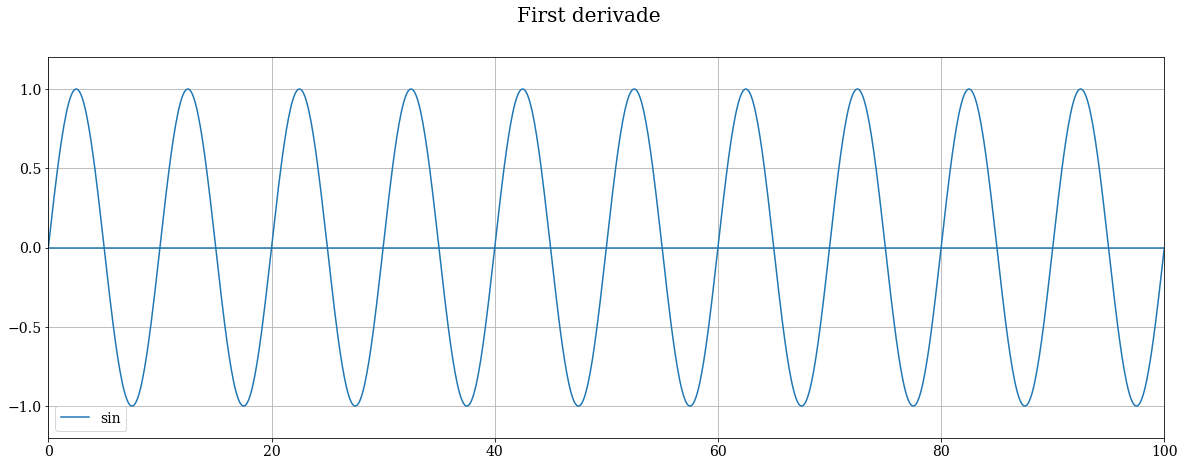

In [183]:
t=np.linspace(0,100,1000)
T=np.sin(2*np.pi*t/10) #periodo 

fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('First derivade',fontsize=20)
ax1.plot(t,T,'-',label='sin');
ax1.axhline(y=0);ax1.grid()
#ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
#ax1.set_ylabel('f*', fontsize = 20)
ax1.legend(loc=3);ax1.set(xlim=[0,100],ylim=[-1.2,1.2])
#ax1.axvline(x=1.5/2)
plt.show()

t samples: 999
deltas_t steps: from 1 to 500
epsilons steps: 500
0  fluctuaciones eliminadas ( 0.0 %)


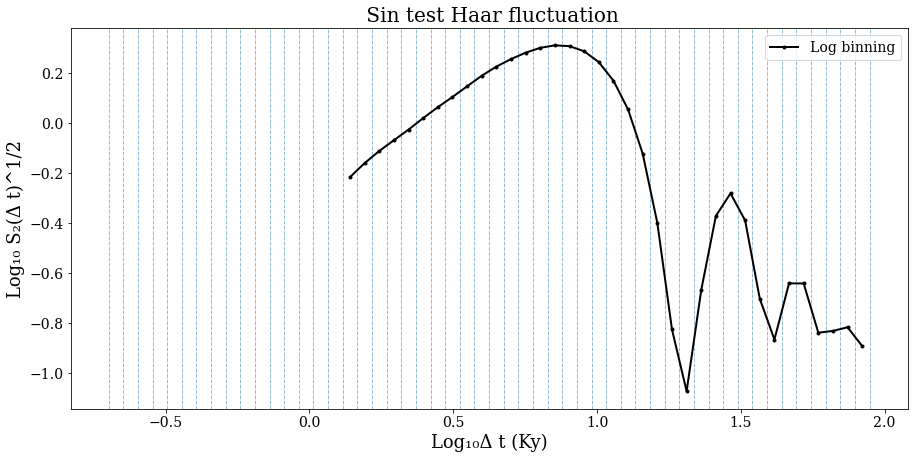

In [184]:
[delta_t,hs,time,amp,app,low]=Haar(t,T,plot=True,smooth=True)

36
Slope izq 0.795912354878637
Slope der -1.069559199438536


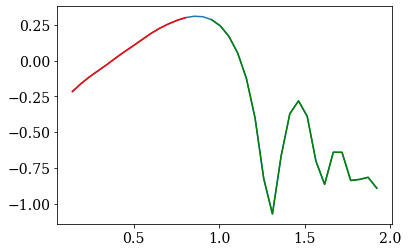

In [190]:
print(len(time))
plt.plot(time,np.log10(amp))
plt.plot(time[:14],np.log10(amp[:14]),color='r')
plt.plot(time[16:],np.log10(amp[16:]),color='g')
print('Slope izq',linregress(time[:14], np.log10(amp[:14]))[0])
print('Slope der',linregress(time[16:], np.log10(amp[16:]))[0])

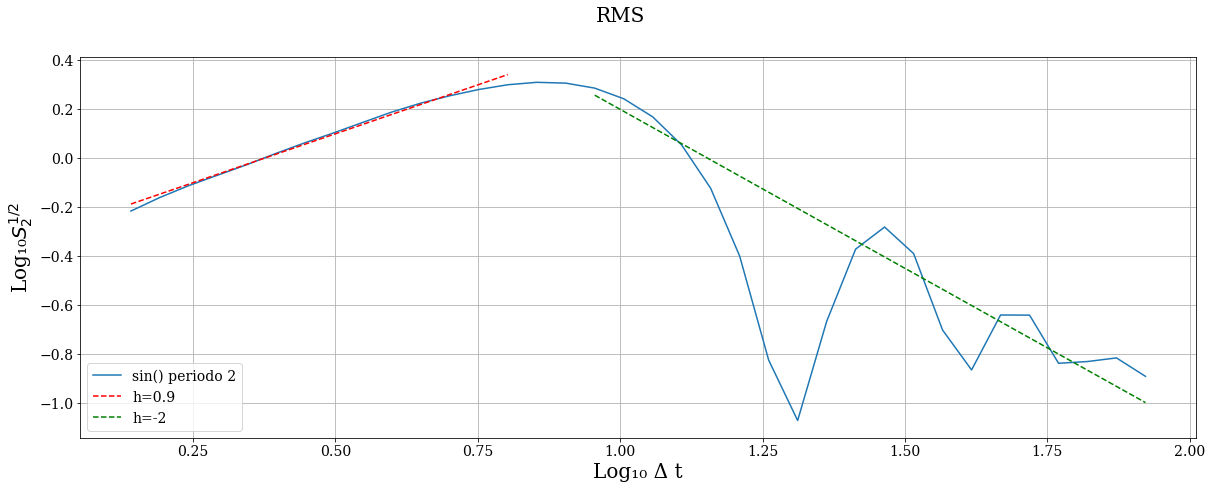

In [205]:
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('RMS',fontsize=20)
#ax1.plot(np.log10(delta_t),np.log10(np.sqrt(hs)),'.',label='sin periodo 1');
ax1.plot(time,np.log10(amp),'-',label='sin() periodo 2');
ax1.plot(time[:14],0.8*time[:14]-0.3,'--',color='r',label='h=0.9')
ax1.plot(time[16:],-1.3*time[16:]+1.5,'--',color='g',label='h=-2')
#ax1.axhline(y=0);
ax1.grid()
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_{2}^{1/2}$', fontsize = 20)
ax1.legend(loc=3);#ax1.set(xlim=[0,1],ylim=[-1.2,1.2])
plt.show()

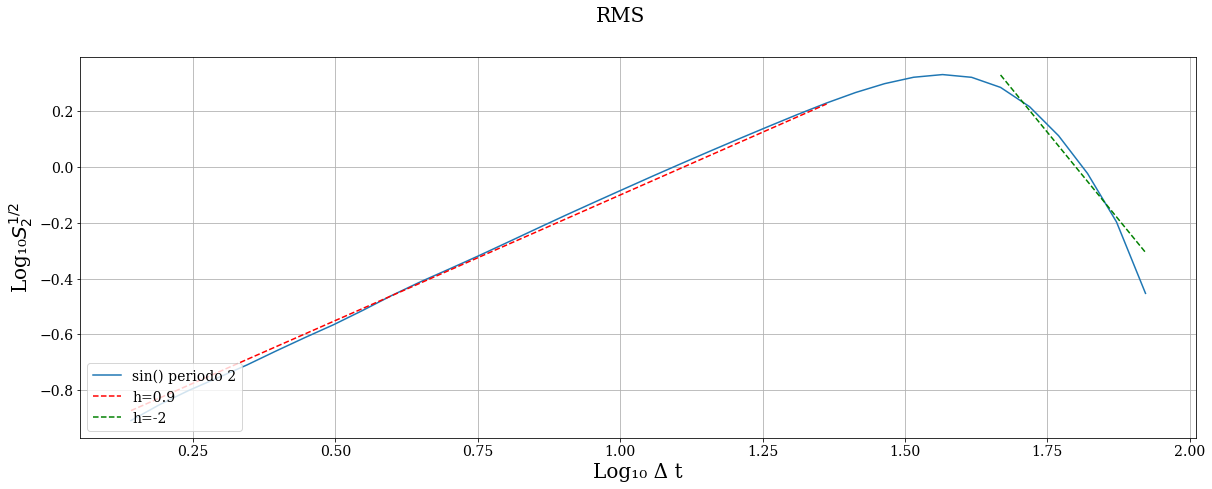

In [182]:
fig, (ax1) = plt.subplots(1,1,figsize=(20, 7));fig.suptitle('RMS',fontsize=20)
#ax1.plot(np.log10(delta_t),np.log10(np.sqrt(hs)),'.',label='sin periodo 1');
ax1.plot(time,np.log10(amp),'-',label='sin() periodo 2');
ax1.plot(time[:25],0.9*time[:25]-1,'--',color='r',label='h=0.9')
ax1.plot(time[30:],-2.5*time[30:]+4.5,'--',color='g',label='h=-2')
#ax1.axhline(y=0);
ax1.grid()
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_{2}^{1/2}$', fontsize = 20)
ax1.legend(loc=3);#ax1.set(xlim=[0,1],ylim=[-1.2,1.2])
plt.show()

In [135]:
np.log10(50)

1.6989700043360187

### Primero probaré con opción más manual.
Tengo que definir los puntos que tomaré para interpolar, hasta donde lo haré (70%) y la distancia que compararé (dif)

Tomando  4  points
Posible tau_c:  1791.19223627969  y   dif n° 3
Posible tau_c:  2010.1518866826873  y   dif n° 4
Posible tau_c:  2255.8776917917708  y   dif n° 5
Posible tau_c:  4015.5859684124284  y   dif n° 10
Tau_c [ 0.24 , 0.51 ]
=     [ 1751.8 , 3260.0 ] years


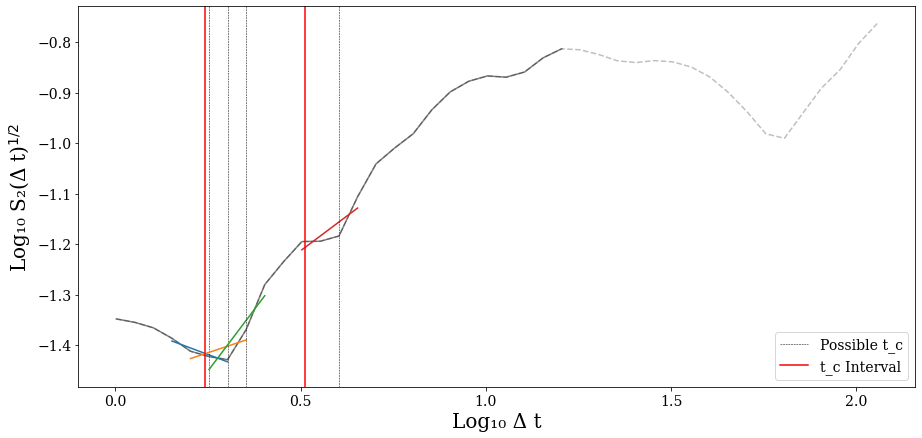

In [499]:
points=int(len(time)*0.1) #10% de los binnings
print('Tomando ',points,' points')
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'--',color='grey',alpha=0.5)

slopes=np.array([])
interceptions=np.array([])
rango=int(len(time)*0.7)-points #evaluar el 70% de los datos izquierdo PORUQE - POINTS!?
plt.plot(time[:rango],np.log10(amp[:rango]),'-',color='black',alpha=0.5)

for i in range(rango): #Porque hasta -1? 
    slopes=np.append(slopes,linregress(time[i:i+points], np.log10(amp[i:i+points]))[0])
    interceptions=np.append(interceptions,linregress(time[i:i+points], np.log10(amp[i:i+points]))[1])
    #plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
    #print('slope ',i+1,': ',time[i:i+points],' ->',slopes[-1])

#plt.title('Slope estimation with '+str(points)+' points')
#plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
#plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#plt.savefig('0-Code steps1-Points3.jpg',bbox_inches='tight')
#plt.show()    


dif=1
slope_dif=slopes[:-dif]-slopes[dif:] #Diferencia de 1 con el que vieneee, probar cambiar
threshold=np.mean(slope_dif)-np.std(slope_dif)

possible_tc=np.array([])
slopes_stored=np.array([])
interceptions_stoder=np.array([])
indice=[]
label=0
for i in range (len(slope_dif)):#for i in range(len(time[1:-points-1])):    
    if slope_dif[i]<threshold:
        if label==0:
            indice.append(i)            
            plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
            #plt.plot(time[i+dif:i+dif+points],time[i+dif:i+dif+points]*slopes[i+dif]+interceptions[i+dif],'-')
            possible_tc=np.append(possible_tc,time[i+int(points/2)]) #el posible será el punto medio?
            plt.axvline(possible_tc[-1],color='black',linestyle='--',linewidth=0.5,label='Possible t_c') 
            slopes_stored=np.append(slopes_stored,slopes[i])
            interceptions_stoder=np.append(interceptions_stoder,interceptions[i])
            print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
                   
        if label!=0:            
            indice.append(i)
            #plt.axvline(time[i+int(points/2)],color='r',label='cambio fuerte') 
            plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
            #plt.plot(time[i+dif:i+dif+points],time[i+dif:i+dif+points]*slopes[i+dif]+interceptions[i+dif],'.-')
            possible_tc=np.append(possible_tc,time[i+int(points/2)]) #el posible será el punto medio?
            plt.axvline(possible_tc[-1],color='black',linestyle='--',linewidth=0.5) 
            slopes_stored=np.append(slopes_stored,slopes[i])
            interceptions_stoder=np.append(interceptions_stoder,interceptions[i])
            print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
        label+=1
#plt.title('Differences: S[i]-S[i+'+str(dif)+']')
#plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
#plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#plt.savefig('0-Code steps2-diff5.jpg',bbox_inches='tight')
#plt.show()    
       
tc_upp=np.mean(possible_tc)+np.std(possible_tc)
tc_low=np.mean(possible_tc)-np.std(possible_tc)

plt.axvline(tc_upp,color='r',linestyle='-',label='t_c Interval') 
plt.axvline(tc_low,color='r',linestyle='-')
plt.legend()
plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)

print('Tau_c [',np.round(tc_low,2),',',np.round(tc_upp,2),']')
print('=     [',np.round(10**tc_low*1000,1),',',np.round(10**tc_upp*1000,1),'] years')

#plt.title('6 points slope - Diff: S[i] - S[i+1]] < threshold')
#plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
#plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#plt.savefig('0-Code steps5-6.jpg',bbox_inches='tight')




plt.savefig(str(ix)+' Tau_c v1.jpg',bbox_inches='tight')
plt.show()

### Ahora pruebo con Savgol-Filter
Misma idea

29
Posible tau_c:  2255.8776917917708  y   dif n° 6
Posible tau_c:  2531.641610784952  y   dif n° 7
Posible tau_c:  4506.460862797284  y   dif n° 12
Tau_c [ 0.34 , 0.6 ]
=     [ 2181.3 , 3996.2 ] years


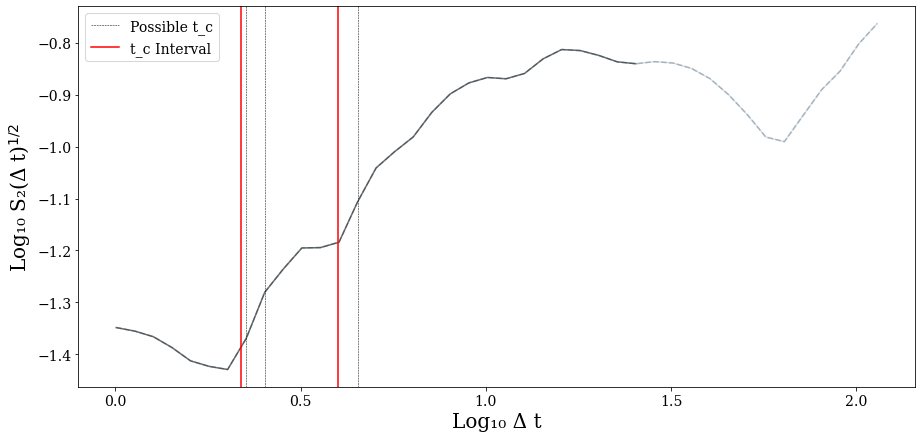

In [497]:
plt.subplots(figsize=(15,7))
rango=int(len(time)*0.7)#evaluar el 70% de los datos izquierdo
print(rango)
points=3
order=2
plt.plot(time,np.log10(amp),alpha=0.2)
plt.plot(time,savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=0,mode='nearest'),'--',color='grey',alpha=0.5)
plt.plot(time[:rango],savgol_filter(np.log10(amp[:rango]), window_length=points, polyorder=order, deriv=0,mode='nearest'),'-',color='black',alpha=0.5)

der1=savgol_filter(np.log10(amp[:rango-points]), window_length=points, polyorder=order, deriv=1,mode='nearest')
der2=savgol_filter(np.log10(amp[:rango-points]), window_length=points, polyorder=order, deriv=2,mode='nearest')

threshold=np.mean(der2)+np.std(der2)
#plt.plot(time[:rango],der2,'.-',label='delta1');
#plt.axhline(y=threshold,linestyle='-',color='r',label='delta1');

possible_tc=np.array([])
label=0
for i in range(len(der2)):

    if der2[i]>threshold :#and der2[i]>0:
            if label==0:
                indice.append(i)            
                #plt.plot(time[i:i+points],time[i:i+points]*der1[i]+np.log10(amp[i]),'-')
                #plt.plot(time[i+dif:i+dif+points],time[i+dif:i+dif+points]*slopes[i+dif]+interceptions[i+dif],'-')
                possible_tc=np.append(possible_tc,time[i+int(points/2)]) #el posible será el punto medio?
                plt.axvline(possible_tc[-1],color='black',linestyle='--',linewidth=0.5,label='Possible t_c') 
                print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
                

            if label!=0:            
                indice.append(i)            
                #plt.plot(time[i:i+points],time[i:i+points]*der1[i]+np.log10(amp[i]),'-')
                #plt.plot(time[i+dif:i+dif+points],time[i+dif:i+dif+points]*slopes[i+dif]+interceptions[i+dif],'-')
                possible_tc=np.append(possible_tc,time[i+int(points/2)]) #el posible será el punto medio?
                plt.axvline(possible_tc[-1],color='black',linestyle='--',linewidth=0.5) 
                print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
            label+=1

tc_upp=np.mean(possible_tc)+np.std(possible_tc)
tc_low=np.mean(possible_tc)-np.std(possible_tc)

plt.axvline(tc_upp,color='r',linestyle='-',label='t_c Interval') 
plt.axvline(tc_low,color='r',linestyle='-')
plt.legend()
print('Tau_c [',np.round(tc_low,2),',',np.round(tc_upp,2),']')
print('=     [',np.round(10**tc_low*1000,1),',',np.round(10**tc_upp*1000,1),'] years')

plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)

plt.savefig(str(ix)+' Tau_c v2.jpg',bbox_inches='tight')
#plt.savefig('reference Tau_c v2.jpg',bbox_inches='tight')

plt.show()

45
Posible tau_c:  4758.724600140263  y   dif n° 28
Posible tau_c:  5339.75487288662  y   dif n° 29
Posible tau_c:  5991.7277208426785  y   dif n° 30
Posible tau_c:  6723.3050833487005  y   dif n° 31
Tau_c [ 0.6966006173907029 , 0.8084727730541486 ]
o     [ 4972.795701628631 , 6433.877282330563 ] y


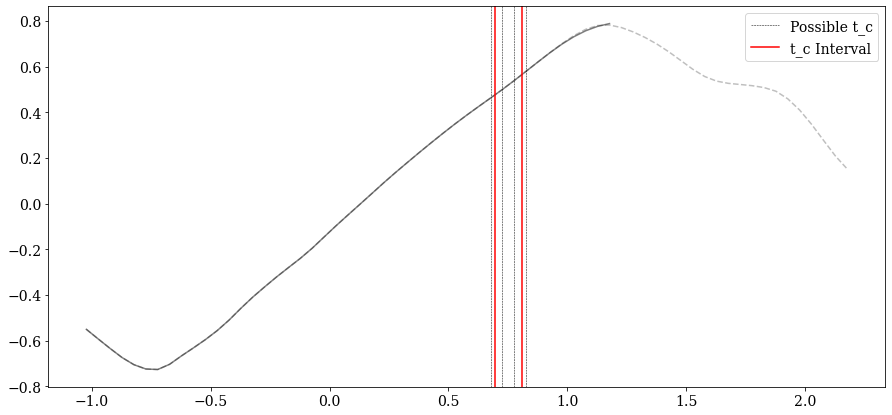

In [365]:
plt.subplots(figsize=(15,7))
rango=int(len(time)*0.7)#evaluar el 70% de los datos izquierdo
print(rango)
points=13
order=2
#plt.plot(time,np.log10(amp))
plt.plot(time,savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=0,mode='nearest'),'--',color='grey',alpha=0.5)
plt.plot(time[:rango],savgol_filter(np.log10(amp[:rango]), window_length=points, polyorder=order, deriv=0,mode='nearest'),'-',color='black',alpha=0.5)

der1=savgol_filter(np.log10(amp[:rango-points]), window_length=points, polyorder=order, deriv=1,mode='nearest')
der2=savgol_filter(np.log10(amp[:rango-points]), window_length=points, polyorder=order, deriv=2,mode='nearest')

threshold=np.mean(der2)-np.std(der2)
#plt.plot(time[:rango],der2,'.-',label='delta1');
#plt.axhline(y=threshold,linestyle='-',color='r',label='delta1');

possible_tc=np.array([])
label=0
for i in range(len(der2)):

    if der2[i]<threshold:
            if label==0:
                indice.append(i)            
                #plt.plot(time[i:i+points],time[i:i+points]*der1[i]+np.log10(amp[i]),'-')
                #plt.plot(time[i+dif:i+dif+points],time[i+dif:i+dif+points]*slopes[i+dif]+interceptions[i+dif],'-')
                possible_tc=np.append(possible_tc,time[i+int(points/2)]) #el posible será el punto medio?
                plt.axvline(possible_tc[-1],color='black',linestyle='--',linewidth=0.5,label='Possible t_c') 
                print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
                

            if label!=0:            
                indice.append(i)            
                #plt.plot(time[i:i+points],time[i:i+points]*der1[i]+np.log10(amp[i]),'-')
                #plt.plot(time[i+dif:i+dif+points],time[i+dif:i+dif+points]*slopes[i+dif]+interceptions[i+dif],'-')
                possible_tc=np.append(possible_tc,time[i+int(points/2)]) #el posible será el punto medio?
                plt.axvline(possible_tc[-1],color='black',linestyle='--',linewidth=0.5) 
                print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
            label+=1

tc_upp=np.mean(possible_tc)+np.std(possible_tc)
tc_low=np.mean(possible_tc)-np.std(possible_tc)

plt.axvline(tc_upp,color='r',linestyle='-',label='t_c Interval') 
plt.axvline(tc_low,color='r',linestyle='-')
plt.legend()
print('Tau_c [',tc_low,',',tc_upp,']')
print('o     [',10**tc_low*1000,',',10**tc_upp*1000,'] y')

#plt.savefig(str(ix)+' Tau_c v2.jpg',bbox_inches='tight')
plt.show()

No handles with labels found to put in legend.


45


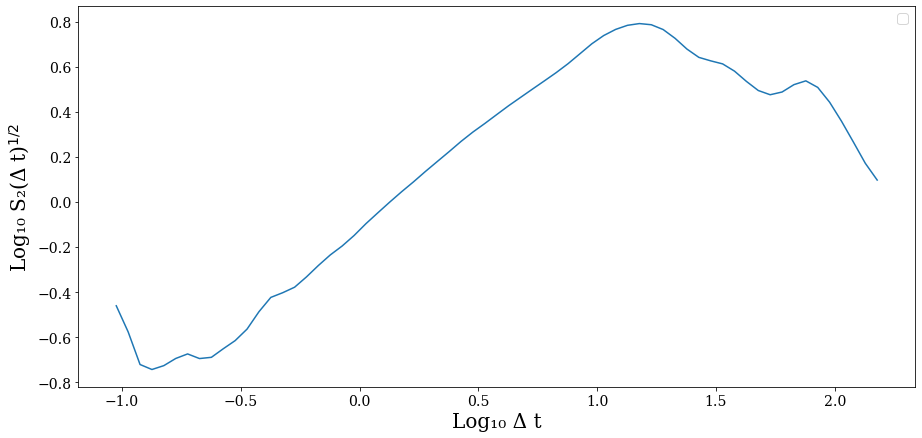

In [480]:
plt.subplots(figsize=(15,7))
rango=int(len(time)*0.7)#evaluar el 70% de los datos izquierdo
print(rango)
points=13
order=2
der1=savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=1,mode='nearest')
der2=savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=2,mode='nearest')

plt.plot(time,np.log10(amp),alpha=1)#,label='original')
#plt.plot(time,savgol_filter(np.log10(amp), window_length=points, polyorder=order, deriv=0,mode='nearest'),'--',color='black',alpha=0.7,label='filtered')
#plt.plot(time,der2)
plt.legend()
#plt.plot(time[:rango],savgol_filter(np.log10(amp[:rango]), window_length=points, polyorder=order, deriv=0,mode='nearest'),'-',color='black',alpha=0.5)
#plt.title('2nd derivative Savitzky–Golay filter')
plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#plt.savefig('0-Code salgov-1-o.jpg',bbox_inches='tight')
plt.show()



